# LSTM Model for Google Stock Price Data
### Claire Kintzley - DSCI 575

## Data Preprocessing

Same as the SimpleRNN model

In [275]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [276]:
# Load data from csv
data = pd.read_csv('GOOG.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.head())
# Only interested in opening price data
GoogOpen = data[['Date', 'Open']]
GoogOpen.set_index('Date', inplace=True)
print(GoogOpen.head())

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1 2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2 2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3 2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
4 2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512
                Open
Date                
2004-08-19  2.490664
2004-08-20  2.515820
2004-08-23  2.758411
2004-08-24  2.770615
2004-08-25  2.614201


### Training/Testing Split

We will first split the data as 90/10 

In [277]:
# Perform 90/10 split
split_index = int(len(GoogOpen) * 0.9) - 50  # Go back 50 days so prediction starts on 12/30/2021
train_open = GoogOpen[:split_index]
test_open = GoogOpen[split_index:]

print(train_open.shape, test_open.shape)
train_open.head()

(4322, 1) (536, 1)


,Open
Date,
2004-08-19,2.490664
2004-08-20,2.515820
2004-08-23,2.758411
2004-08-24,2.770615
2004-08-25,2.614201


In [278]:
# Reshape data into 2-D array
train_dataset = np.reshape(train_open, (-1,1))
print(train_dataset.shape)

test_dataset = np.reshape(test_open, (-1,1))
print(test_dataset.shape)

(4322, 1)
(536, 1)


### Data Normalization

Transforming data values to a (0,1) scale 

In [279]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

train_dataset_scaled = scaler.fit_transform(train_dataset)
test_dataset_scaled = scaler.fit_transform(test_dataset)

### Divide into X and y Datasets

We will create X_train, y_train, X_test, and y_test datasets to form this into a supervised learning problem. We will use a time step of 50 days for training.

In [280]:
# creating X and y for training data

time_step = 50
train_length = len(train_open)

X_train = []
y_train = []

for i in range(time_step, train_length):
    X_train.append(train_dataset_scaled[i - time_step:i,0])
    y_train.append(train_dataset_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(4272, 50)
(4272,)


In [281]:
# creating X and y for testing data
test_length = len(test_open)
X_test = []
y_test = []

for i in range(time_step, test_length):
    X_test.append(test_dataset_scaled[i - time_step:i,0])
    y_test.append(test_dataset_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(486, 50)
(486,)


In [282]:
# Reshape train data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

print(X_train.shape)
print(y_train.shape)

(4272, 50, 1)
(4272, 1)


In [283]:
# Reshape test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(X_test.shape)
print(y_test.shape)

(486, 50, 1)
(486, 1)


## Building an LSTM Model

We will build an LSTM model with 2 LSTM layers and include a dropout layer for each. We will again use the tahn activation function in our layers and the Adam optimizer with an mse loss function. 

In [286]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=50, 
               activation='tanh', 
               return_sequences=True, 
               input_shape=(X_train.shape[1], 1)))

# Add another LSTM layer
model.add(LSTM(units=50, 
               activation='tanh', 
               return_sequences=False))

model.add(Dense(25))

# Output Dense layer for regression
model.add(Dense(1))  # For time series regression, use 1 output neuron

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                  │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 2/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 2.0538e-04 - val_loss: 0.0031
Epoch 3/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 1.9437e-04 - val_loss: 0.0027
Epoch 4/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 1.2628e-04 - val_loss: 0.0022
Epoch 5/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 9.4671e-05 - val_loss: 0.0018
Epoch 6/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 8.0530e-05 - val_loss: 0.0016
Epoch 7/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 1.0234e-04 - val_loss: 0.0019
Epoch 8/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 8.0239e-05 - val_loss: 0.0017
Epoch 9/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 1.0082e-04 - val_loss: 0.0025
Epoch 10/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 6.6893e-05 - val_loss: 0.0014
Epoch 11/12
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 8.4974e-0

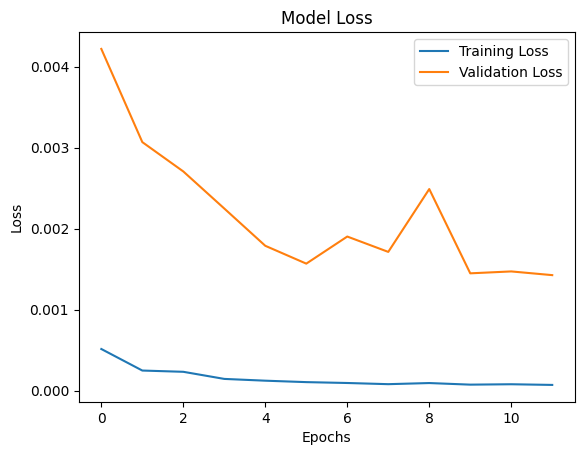

In [287]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Both the training and validation loss are decreasing to a horizontal asymptote and appear relatively smooth, so our model seems to be doing a good job.

In [288]:
# Make predictions on the training and test set
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and true values to the original scale
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train)

test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [289]:
# Extract the corresponding dates for training and test data
train_dates = GoogOpen.index[:len(train_predictions)]
test_dates = GoogOpen.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

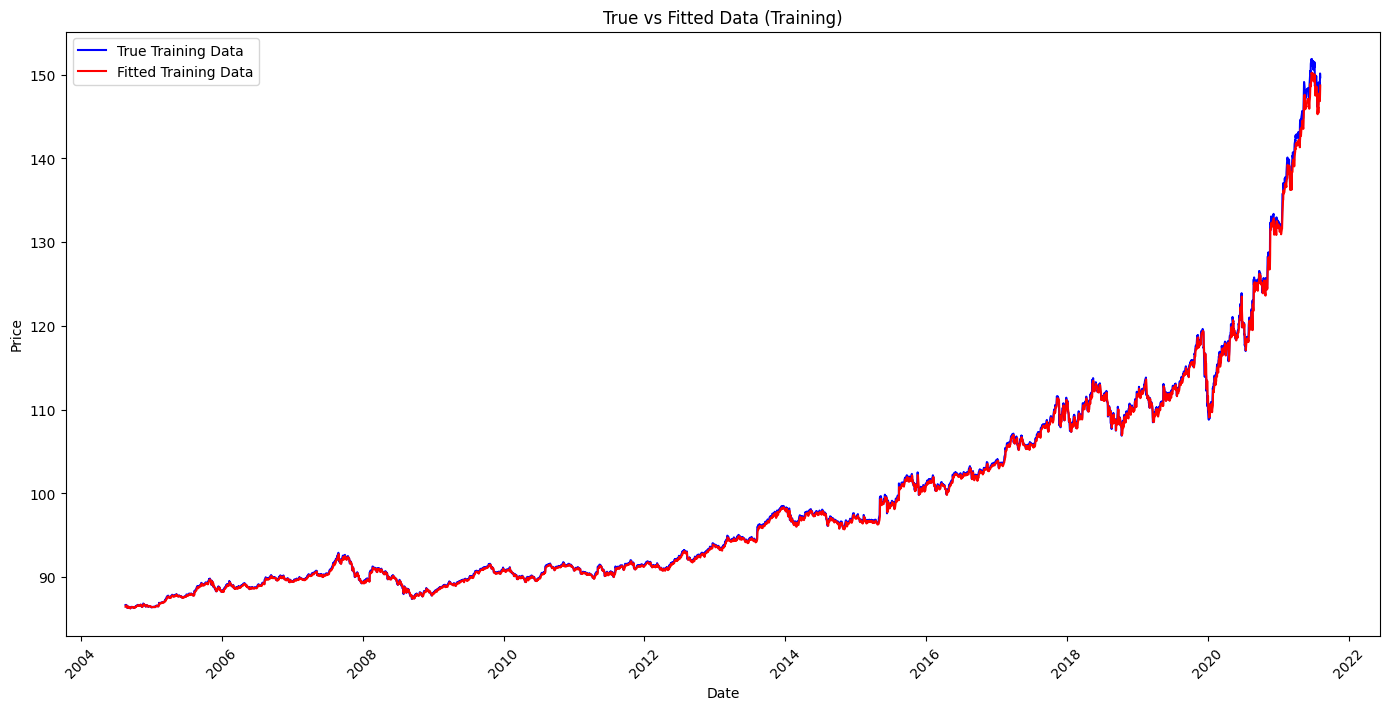

In [290]:
plt.figure(figsize=(14, 7))

# Plot training data with dates on the x-axis
plt.plot(train_dates, y_train_actual, color='blue', label='True Training Data')
plt.plot(train_dates, train_predictions, color='red', label='Fitted Training Data')

# Add title, labels, and legend
plt.title('True vs Fitted Data (Training)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.show()

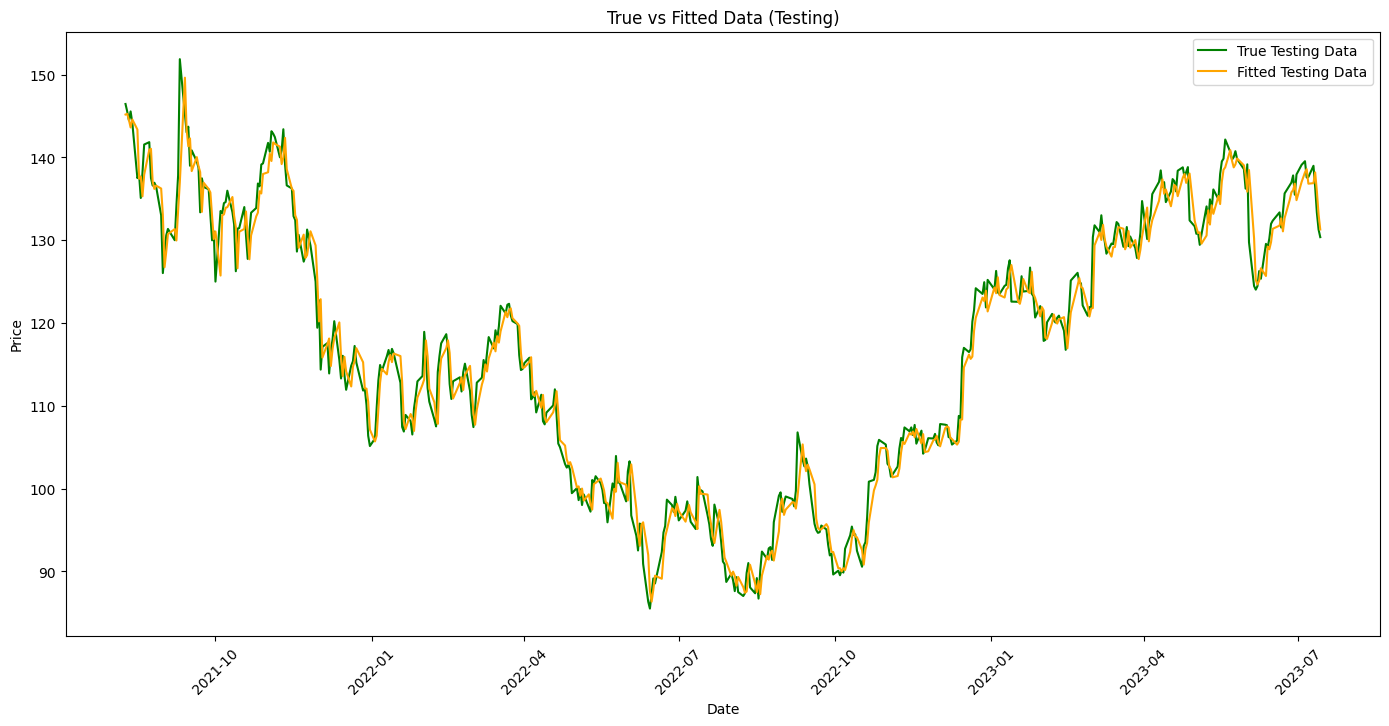

In [291]:
plt.figure(figsize=(14, 7))

# Plot testing data with dates on the x-axis
plt.plot(test_dates, y_test_actual, color='green', label='True Testing Data')
plt.plot(test_dates, test_predictions, color='orange', label='Fitted Testing Data')

# Add title, labels, and legend
plt.title('True vs Fitted Data (Testing)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.show()

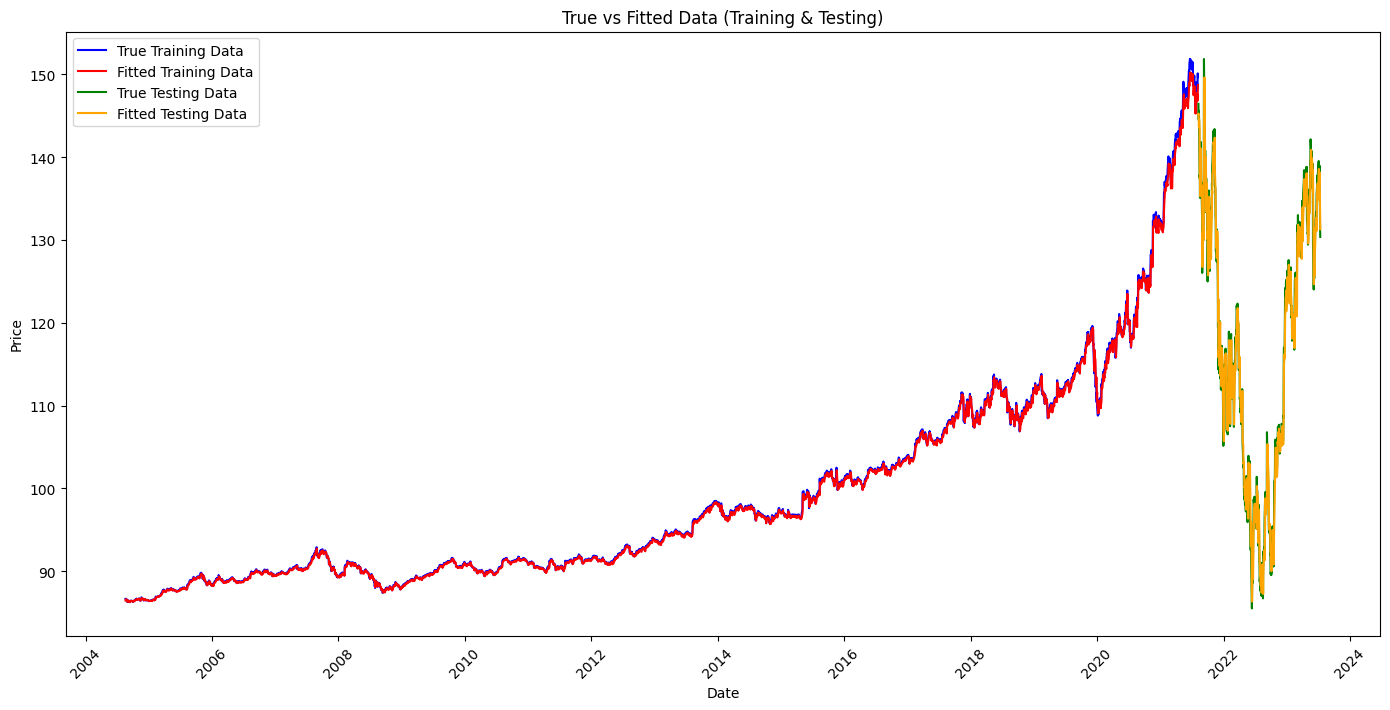

In [292]:
plt.figure(figsize=(14, 7))

# Plot training and testing data with dates on the x-axis
plt.plot(train_dates, y_train_actual, color='blue', label='True Training Data')
plt.plot(train_dates, train_predictions, color='red', label='Fitted Training Data')
plt.plot(test_dates, y_test_actual, color='green', label='True Testing Data')
plt.plot(test_dates, test_predictions, color='orange', label='Fitted Testing Data')

# Add title, labels, and legend
plt.title('True vs Fitted Data (Training & Testing)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.show()


In [293]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate MSE, MAE, RMSE, and MAPE for training data
train_mse = mean_squared_error(y_train_actual, train_predictions)
train_mae = mean_absolute_error(y_train_actual, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mape = np.mean(np.abs((y_train_actual - train_predictions) / y_train_actual))

# Print the results
print(f'Train MSE: {train_mse:.4f}')
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train MAPE: {train_mape:.4f}')

Train MSE: 0.1624
Train MAE: 0.2366
Train RMSE: 0.4030
Train MAPE: 0.0022


In [294]:
test_mse = mean_squared_error(y_test_actual, test_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual))

# Print the results
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAPE: {test_mape:.4f}')

Test MSE: 6.2768
Test MAE: 1.9025
Test RMSE: 2.5054
Test MAPE: 0.0164


In [295]:
# Predicted next day's value
rnn_next_day_pred = test_predictions[0][0]

# Extract the true value for comparison
rnn_next_day_true = GoogOpen.iloc[split_index + 50]['Open']

# Calculate prediction error
rnn_pred_error = abs(rnn_next_day_true - rnn_next_day_pred)

# Print results
print("True value for the next day:", rnn_next_day_true)
print("Predicted value for the next day:", rnn_next_day_pred)
print("Prediction error (absolute):", rnn_pred_error)

True value for the next day: 146.449997
Predicted value for the next day: 145.17857
Prediction error (absolute): 1.2714233916015587
